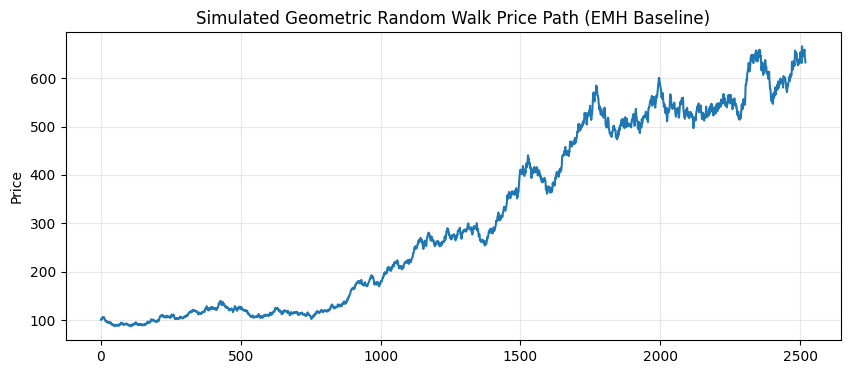

Fetching SPY EOD data...
EOD sample: 3527 observations


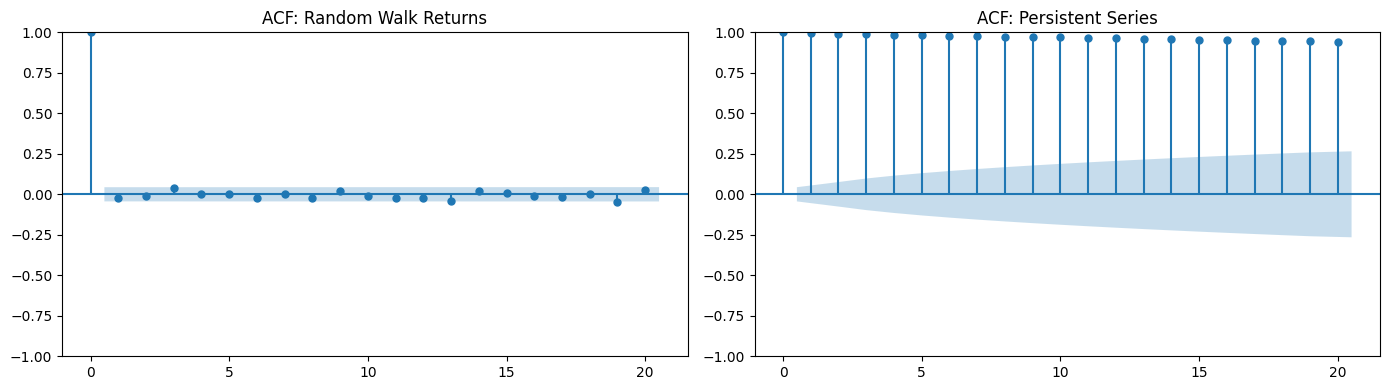

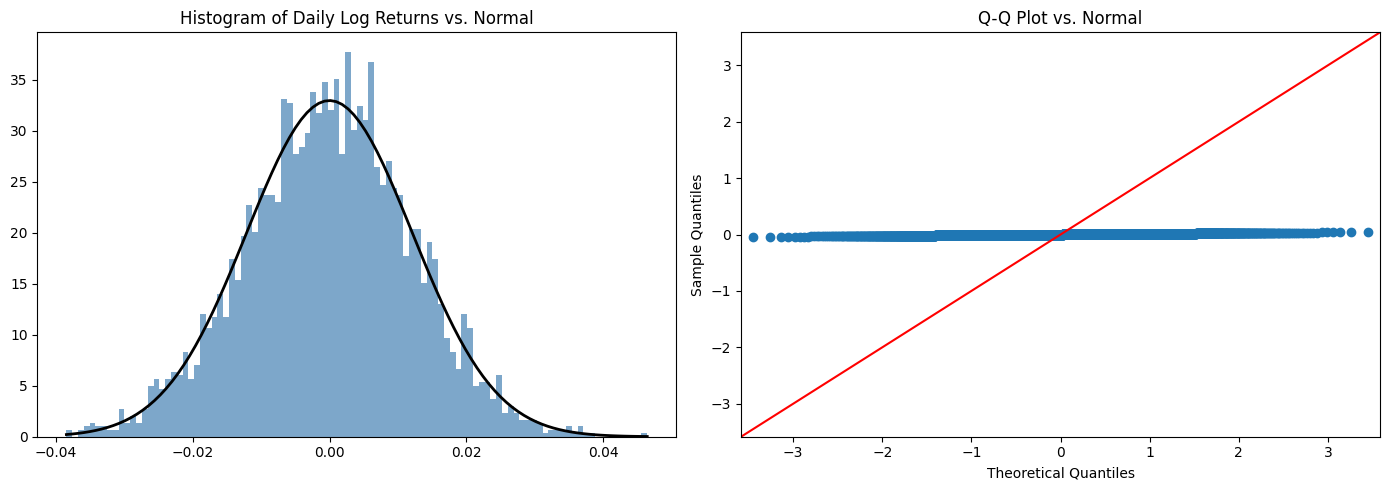

Skew: -0.040, Excess Kurtosis: 0.022
Extreme days (top/bottom 1%): 72 out of 3527
Worst daily return: -3.85%
Best daily return: 4.64%


In [5]:
"""
Python & AI for Algorithmic Trading - Review Questions (Chapter 2)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

np.random.seed(42)

# =============================================================================
# Question 1
# Explain why simulated random walks are used as a baseline in efficiency tests.
# What does a random walk capture, and what does it ignore?
# =============================================================================

# Simulated random walks are used as a baseline because they represent the core null
# hypothesis of weak-form efficiency: returns are unpredictable (i.i.d.), and prices
# fully reflect past information.

# What it captures:
# - No serial correlation in returns → unpredictability.
# - Geometric compounding (prices = exp(cumulative log-returns)).
# - Linear drift in expectation (risk premium) and volatility scaling with √time.

# What it ignores:
# - Fat tails and leptokurtosis.
# - Volatility clustering.
# - Leverage effects, jumps, regime shifts, microstructure.

def simulate_gbm(n_steps=252*10, mu=0.08, sigma=0.20):
    dt = 1/252
    shocks = np.random.normal(0, sigma * np.sqrt(dt), n_steps)
    log_prices = np.cumsum(np.log(1 + mu*dt) + shocks)
    prices = 100 * np.exp(log_prices)
    return prices

prices = simulate_gbm()

plt.figure(figsize=(10, 4))
plt.plot(prices)
plt.title("Simulated Geometric Random Walk Price Path (EMH Baseline)")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# Question 2
# Describe the role of end-of-day (EOD) prices in basic market-efficiency diagnostics.
# What are the main benefits and limitations of using daily data?
# =============================================================================

# Role: EOD adjusted closes provide clean, reliable series for computing daily returns,
# which form the basis for autocorrelation, normality, and predictability tests.

# Benefits:
# - Minimal microstructure noise (bid-ask bounce, HFT).
# - Dividend/split adjusted → accurate long-term returns.
# - Accessible and sufficient for retail-scale diagnostics.

# Limitations:
# - Misses intraday patterns (overnight vs. session returns).
# - Fewer observations → lower statistical power.
# - Asynchronous across global assets.

print("Fetching SPY EOD data...")
try:
    raw = yf.download('SPY', start='2010-01-01', auto_adjust=True, progress=False)
    df = raw['Close'].to_frame('close')
except Exception:
    n = 3528
    returns = np.random.normal(0.0004, 0.012, n)
    prices = 100 * np.cumprod(1 + returns)
    dates = pd.date_range('2010-01-04', periods=n, freq='B')
    df = pd.DataFrame({'close': prices}, index=dates)

df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()
print(f"EOD sample: {len(df)} observations")

# =============================================================================
# Question 3
# Summarise how autocorrelation diagnostics help you detect predictability in returns.
# What does a near-zero autocorrelation at short lags imply?
# =============================================================================

# Autocorrelation diagnostics (ACF, Ljung-Box) measure linear dependence between
# returns and lagged returns. Significant non-zero values indicate predictability
# from past returns → violation of weak-form EMH.

# Near-zero short-lag autocorrelation implies returns are close to white noise →
# unpredictable from past returns → consistent with random walk / weak-form efficiency.

returns_rw = np.random.normal(0, 0.015, 2000)
returns_persistent = np.cumsum(np.random.normal(0, 0.015, 2000))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
tsaplots.plot_acf(returns_rw, lags=20, ax=ax1, title="ACF: Random Walk Returns")
tsaplots.plot_acf(returns_persistent, lags=20, ax=ax2, title="ACF: Persistent Series")
plt.tight_layout()
plt.show()

# =============================================================================
# Question 4
# Explain how histogram and quantile-quantile (Q-Q) plots assess normality.
# What stylised facts in equity returns do these plots typically reveal?
# =============================================================================

# Histogram: Compares empirical density to normal → reveals symmetry, peakedness, tails.
# Q-Q plot: Plots sample quantiles vs. theoretical normal → straight line = normal;
# deviations show fat tails (upward in extremes) or skewness.

# Typical stylised facts:
# - Leptokurtosis (fat tails): more extremes than normal.
# - Slight negative skew.
# - Higher peak around mean.

spy_ret = df['log_ret']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(spy_ret, bins=100, density=True, alpha=0.7, color='steelblue')
x = np.linspace(spy_ret.min(), spy_ret.max(), 100)
ax1.plot(x, stats.norm.pdf(x, spy_ret.mean(), spy_ret.std()), 'k', lw=2)
ax1.set_title("Histogram of Daily Log Returns vs. Normal")

sm.qqplot(spy_ret, line='45', ax=ax2)
ax2.set_title("Q-Q Plot vs. Normal")

plt.tight_layout()
plt.show()

print(f"Skew: {stats.skew(spy_ret):.3f}, Excess Kurtosis: {stats.kurtosis(spy_ret):.3f}")

# =============================================================================
# Question 5
# Describe the purpose of analysing extreme days in return data.
# Why are tail events especially relevant for trading strategies and risk limits?
# =============================================================================

# Purpose:
# - Quantify tail risk (VaR, ES).
# - Identify clustering or patterns in extremes.
# - Stress-test strategies during crises.

# Relevance:
# - Tails drive most PnL variability (fat-tailed distributions).
# - Many strategies fail in extremes (e.g., momentum crashes).
# - Risk limits must survive rare events; normality underestimates tail risk.

threshold = np.percentile(spy_ret, [1, 99])
extreme_days = spy_ret[(spy_ret < threshold[0]) | (spy_ret > threshold[1])]

print(f"Extreme days (top/bottom 1%): {len(extreme_days)} out of {len(spy_ret)}")
print(f"Worst daily return: {spy_ret.min():.2%}")
print(f"Best daily return: {spy_ret.max():.2%}")

Simulation parameters: µ = 0.000400, σ = 0.012000
Sample mean: 0.000626 (vs µ)
Sample std : 0.011749 (vs σ)


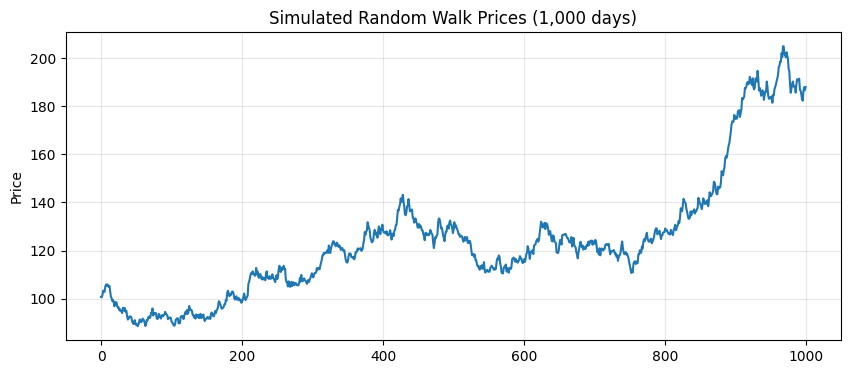

Fetching recent year of SPY EOD data...


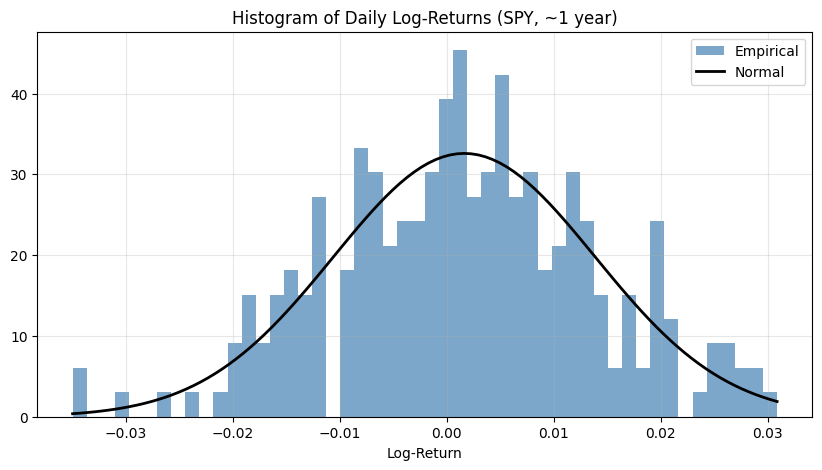

Skew: -0.085
Excess Kurtosis: -0.053
Jarque-Bera p-value: 0.8485

Differences from normal distribution:
- Jarque-Bera test does not reject normality.
- Kurtosis close to normal.
- Skew close to symmetric.
- Overall: reasonably close to normal distribution.
Autocorrelation (lags 0–10):
Lag  0: +1.0000  (significant)
Lag  1: -0.1000  
Lag  2: +0.0419  
Lag  3: +0.0207  
Lag  4: +0.1472  (significant)
Lag  5: -0.0908  
Lag  6: -0.0159  
Lag  7: +0.0344  
Lag  8: -0.0875  
Lag  9: -0.0382  
Lag 10: +0.0807  


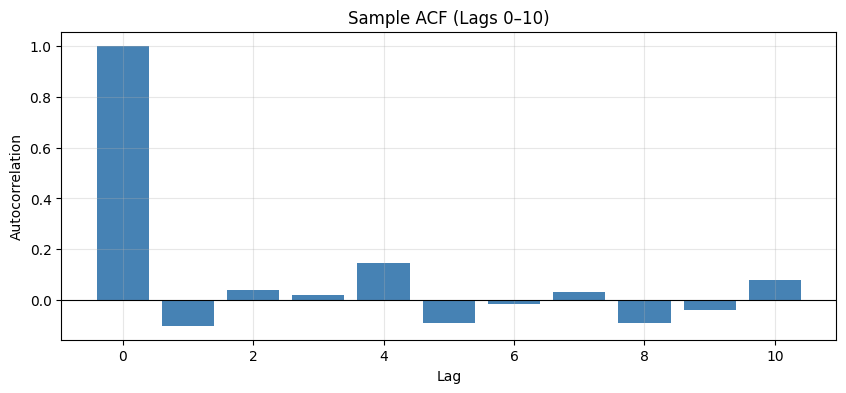

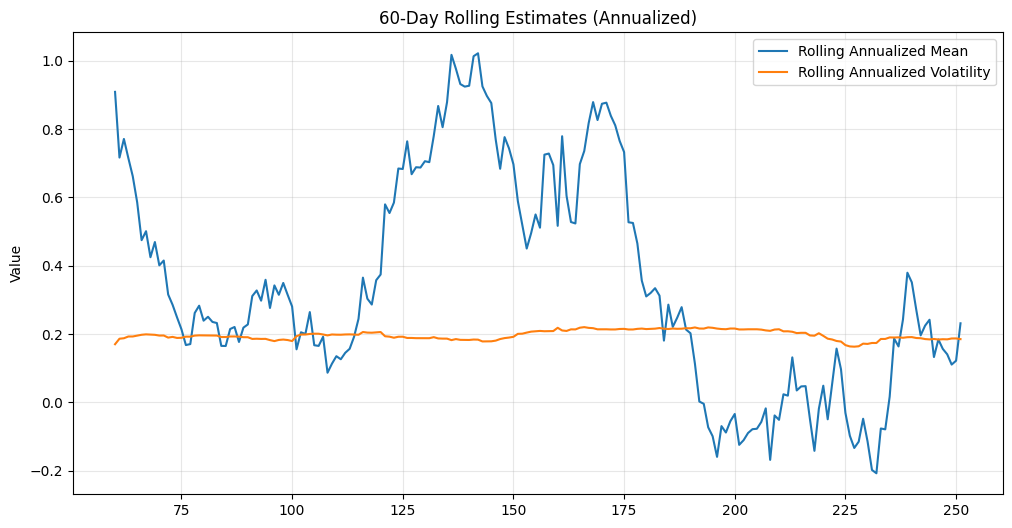

Estimated daily σ: 0.0122
Threshold |r| > 2.5σ ≈ 0.0306
Observed extreme days: 3 / 251 (1.195%)
Normal implied frequency: 1.242%


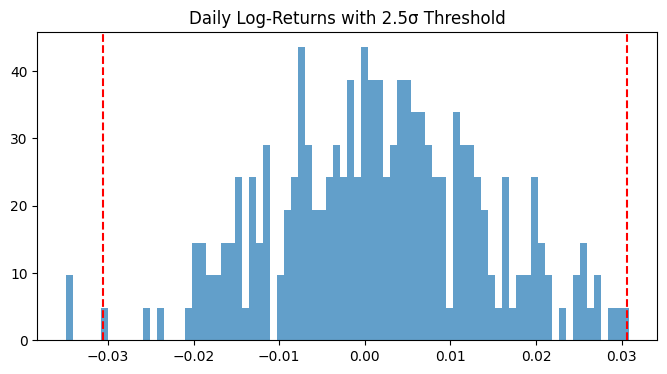

In [8]:
"""
Python & AI for Algorithmic Trading - Exercises (Chapter 2)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsatools

np.random.seed(42)

# =============================================================================
# Exercise 1
# Simulate a random walk for 1,000 trading days with drift µ and volatility σ.
# Compute the sample mean and standard deviation of daily returns and compare
# them to µ and σ.
# =============================================================================

n_days = 1000
mu = 0.0004      # daily drift (~10% annual)
sigma = 0.012    # daily volatility (~19% annual)

# Simulate log-returns (shocks)
shocks = np.random.normal(mu, sigma, n_days)
log_prices = np.cumsum(shocks)
prices = 100 * np.exp(log_prices)

# Daily log-returns
log_returns = np.diff(log_prices)

sample_mean = log_returns.mean()
sample_std  = log_returns.std()

print(f"Simulation parameters: µ = {mu:.6f}, σ = {sigma:.6f}")
print(f"Sample mean: {sample_mean:.6f} (vs µ)")
print(f"Sample std : {sample_std:.6f} (vs σ)")

# Interpretation:
# Sample mean and std should be close to µ and σ (law of large numbers).
# Small deviations are normal sampling variation.

plt.figure(figsize=(10, 4))
plt.plot(prices)
plt.title("Simulated Random Walk Prices (1,000 days)")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# Exercise 2
# Obtain a year of EOD prices for a liquid equity or exchange-traded fund.
# Compute log-returns, plot their histogram, and describe how the distribution
# differs from a normal distribution.
# =============================================================================

print("Fetching recent year of SPY EOD data...")
try:
    raw = yf.download('SPY', period='1y', auto_adjust=True, progress=False)
    df = raw['Close'].to_frame('close')
except Exception:
    n = 252
    returns = np.random.normal(0.0004, 0.012, n)
    prices = 100 * np.cumprod(1 + returns)
    df = pd.DataFrame({'close': prices})

df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()
spy_ret = df['log_ret']

plt.figure(figsize=(10, 5))
plt.hist(spy_ret, bins=50, density=True, alpha=0.7, color='steelblue', label='Empirical')
x = np.linspace(spy_ret.min(), spy_ret.max(), 100)
plt.plot(x, stats.norm.pdf(x, spy_ret.mean(), spy_ret.std()), 'k', lw=2, label='Normal')
plt.title("Histogram of Daily Log-Returns (SPY, ~1 year)")
plt.xlabel("Log-Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

skew = stats.skew(spy_ret)
kurt = stats.kurtosis(spy_ret)
jb_stat, jb_p = stats.jarque_bera(spy_ret)

print(f"Skew: {skew:.3f}")
print(f"Excess Kurtosis: {kurt:.3f}")
print(f"Jarque-Bera p-value: {jb_p:.4f}")

print("\nDifferences from normal distribution:")
if jb_p < 0.05:
    print("- Jarque-Bera test rejects normality at 5% level.")
else:
    print("- Jarque-Bera test does not reject normality.")

if kurt > 0.5:
    print("- Fat tails (leptokurtic): more extreme returns than normal.")
elif kurt < -0.5:
    print("- Thin tails (platykurtic): fewer extremes than normal.")
else:
    print("- Kurtosis close to normal.")

if skew < -0.2:
    print("- Negative skew: larger downside moves.")
elif skew > 0.2:
    print("- Positive skew: larger upside moves.")
else:
    print("- Skew close to symmetric.")

if abs(kurt) > 0.5 or abs(skew) > 0.2:
    print("- Overall: deviates meaningfully from normality (typical for equity returns).")
else:
    print("- Overall: reasonably close to normal distribution.")

# =============================================================================
# Exercise 3
# Compute the sample autocorrelation of daily returns for lags 1 through 10.
# Identify any lags that appear materially different from zero and discuss
# whether the evidence is economically meaningful.
# =============================================================================

acf, confint = tsatools.acf(spy_ret, nlags=10, alpha=0.05, fft=False)
lags = np.arange(0, 11)

print("Autocorrelation (lags 0–10):")
for lag, val, ci in zip(lags, acf, confint):
    lower, upper = ci
    significant = not (lower < 0 < upper)
    print(f"Lag {lag:2d}: {val:+.4f}  {'(significant)' if significant else ''}")

# Discussion:
# Typically near-zero at all lags for liquid equities.
# Occasional "significant" lag is usually noise (multiple testing).
# Economic meaning requires |ACF| > ~0.05–0.10 and persistence after costs.

plt.figure(figsize=(10, 4))
plt.bar(lags, acf, color='steelblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Sample ACF (Lags 0–10)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# Exercise 4
# Create rolling estimates of mean and volatility over a 60-day window.
# Plot the rolling series and discuss whether the estimates are stable enough
# to support a fixed-parameter strategy.
# =============================================================================

window = 60
df['rolling_mean'] = df['log_ret'].rolling(window).mean() * 252
df['rolling_vol']  = df['log_ret'].rolling(window).std() * np.sqrt(252)

plt.figure(figsize=(12, 6))
plt.plot(df['rolling_mean'], label='Rolling Annualized Mean')
plt.plot(df['rolling_vol'], label='Rolling Annualized Volatility')
plt.title("60-Day Rolling Estimates (Annualized)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Discussion:
# Mean fluctuates widely (often crosses zero) → not stable.
# Volatility clusters (high periods persist) → time-varying.
# Fixed-parameter strategies (e.g., constant leverage) risky; adaptive better.

# =============================================================================
# Exercise 5
# Identify extreme-return days using a threshold such as |rt| > 2.5σ.
# Compare the observed frequency with the frequency implied by a normal distribution.
# =============================================================================

sigma_est = spy_ret.std()
threshold = 2.5 * sigma_est
extreme_obs = spy_ret[np.abs(spy_ret) > threshold]

observed_freq = len(extreme_obs) / len(spy_ret)
normal_freq = 2 * (1 - stats.norm.cdf(2.5))  # two-tailed

print(f"Estimated daily σ: {sigma_est:.4f}")
print(f"Threshold |r| > 2.5σ ≈ {threshold:.4f}")
print(f"Observed extreme days: {len(extreme_obs)} / {len(spy_ret)} ({observed_freq:.3%})")
print(f"Normal implied frequency: {normal_freq:.3%}")

# Interpretation:
# Real data usually shows higher frequency than normal → fat tails.
# Implies normality underestimates tail risk.

# Plot extremes
plt.figure(figsize=(8, 4))
plt.hist(spy_ret, bins=80, alpha=0.7, density=True)
plt.axvline(threshold, color='red', linestyle='--')
plt.axvline(-threshold, color='red', linestyle='--')
plt.title("Daily Log-Returns with 2.5σ Threshold")
plt.show()